# Lab 9: Ensemble Classification

 <h2 style="text-align: center;">Name: Neelanajn Dutta </h2>

 <h2 style="text-align: center;">Registration number: 2448040 </h2>

In [205]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [206]:
# Load the Titanic dataset
titanic_df = pd.read_csv("D:/titanic.csv")

In [207]:
# Display basic statistics
print(titanic_df.describe())
print("\n")
print(titanic_df.info())

       PassengerId  Survived    Pclass      Age         SibSp       Parch       Fare      
count  891.000000   891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean   446.000000     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std    257.353842     0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      1.000000     0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%    223.500000     0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%    446.000000     0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%    668.500000     1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max    891.000000     1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------

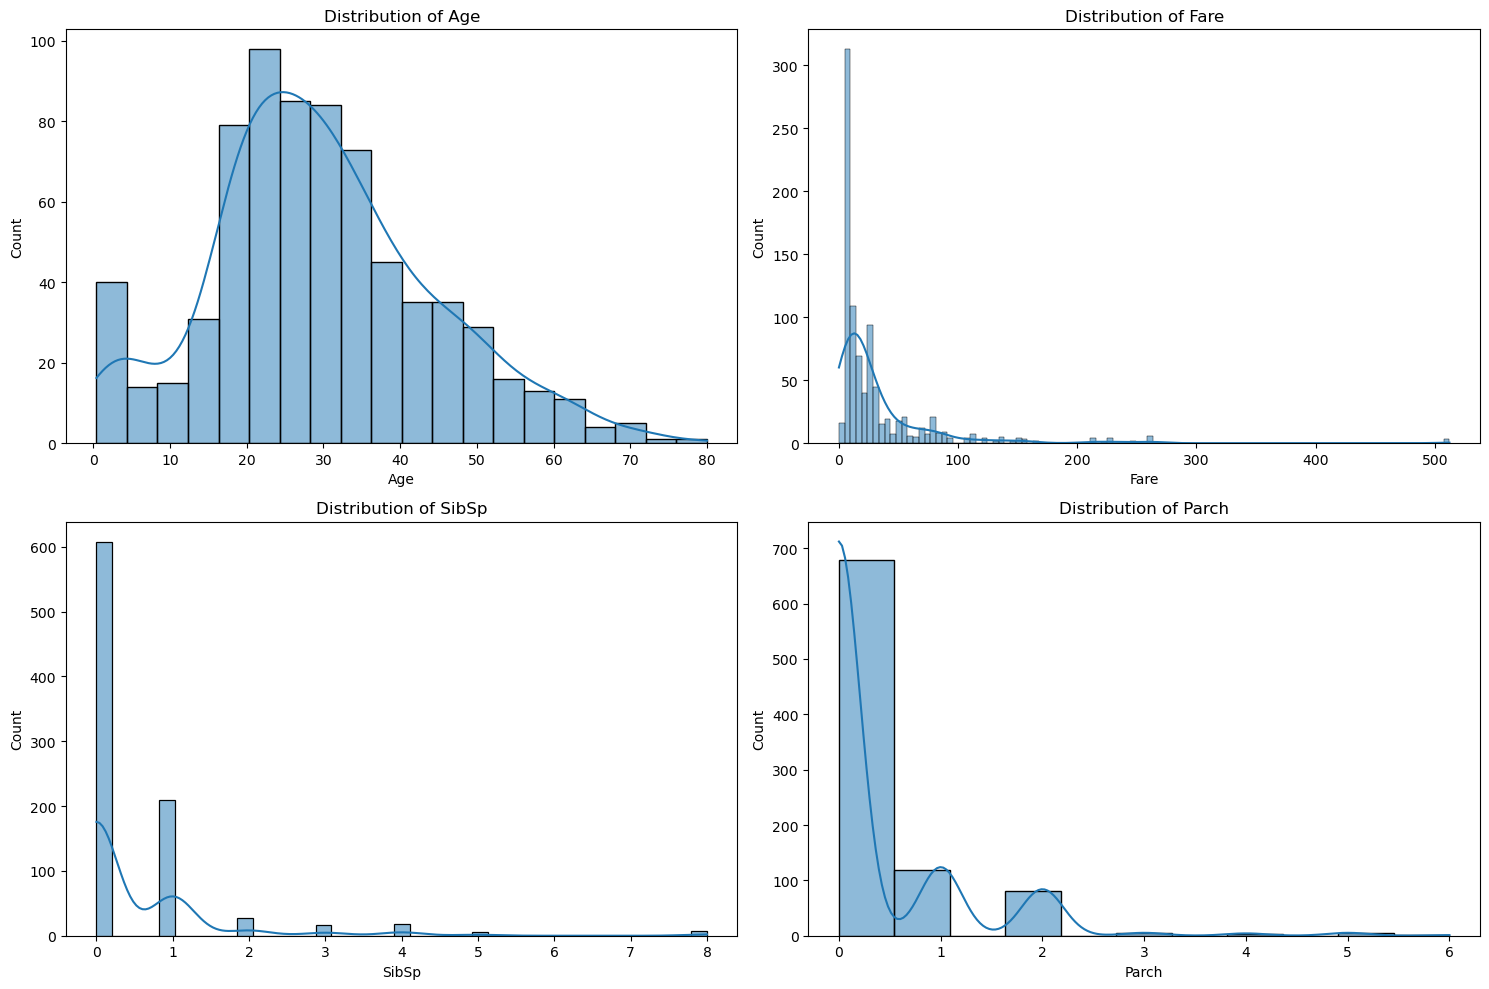

Histograms show the distribution of numerical features such as Age, Fare, SibSp (siblings/spouses aboard), and Parch (parents/children aboard).


In [208]:
# Visualize the distribution of numerical features
plt.figure(figsize=(15, 10))
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(titanic_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()
print("Histograms show the distribution of numerical features such as Age, Fare, SibSp (siblings/spouses aboard), and Parch (parents/children aboard).")

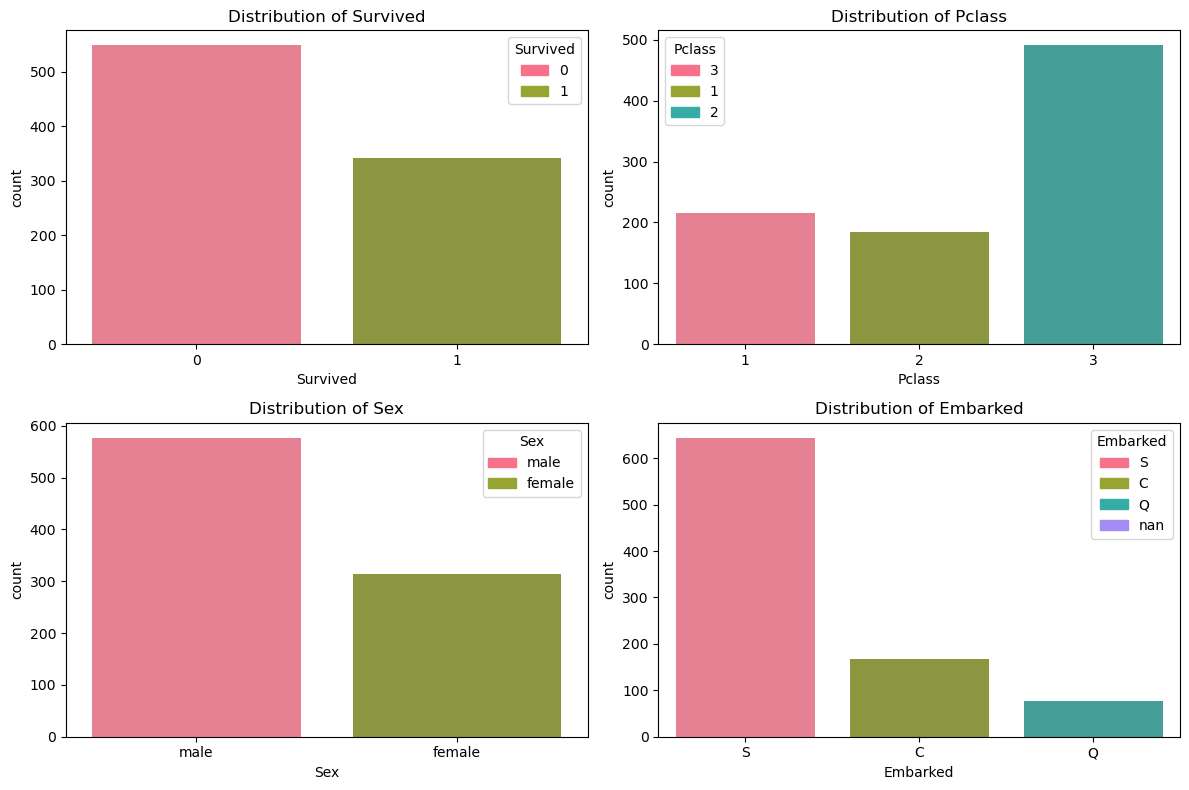

Count plots show the distribution of categorical features such as Survived, Pclass (passenger class), Sex, and Embarked (port of embarkation).


In [209]:
# Define categorical features
categorical_features = ['Survived', 'Pclass', 'Sex', 'Embarked']

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten for easier indexing

# Get default color palette from Seaborn
palette = sns.color_palette("husl", len(categorical_features))

# Plot each categorical feature
for i, feature in enumerate(categorical_features):
    ax = axes[i]
    sns.countplot(x=feature, data=titanic_df, ax=ax, palette=palette)
    ax.set_title(f'Distribution of {feature}')
    
    # Create custom legend
    handles = [plt.Rectangle((0,0),1,1, color=palette[j]) for j in range(len(titanic_df[feature].unique()))]
    labels = titanic_df[feature].unique()
    ax.legend(handles, labels, title=feature)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()
print("Count plots show the distribution of categorical features such as Survived, Pclass (passenger class), Sex, and Embarked (port of embarkation).")

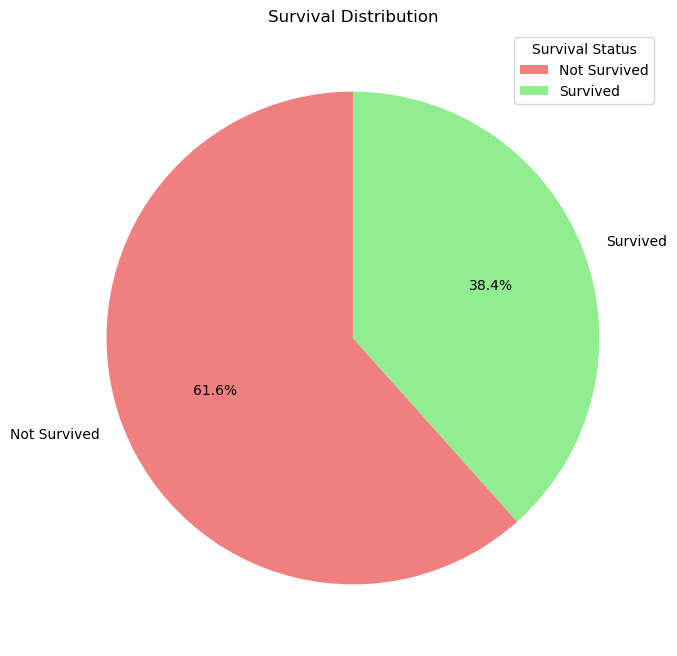

Pie chart shows the proportion of passengers who survived and did not survive.


In [210]:
# Pie chart for the 'Survived' column
survived_counts = titanic_df['Survived'].value_counts()

# Define labels and colors
labels = ['Not Survived', 'Survived']  # Assuming 0 = Not Survived, 1 = Survived
colors = ['lightcoral', 'lightgreen']  # Custom colors

# Create Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(survived_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

# Add Legend
plt.legend(labels, title="Survival Status", loc="upper right")

# Title and Show Plot
plt.title('Survival Distribution')
plt.show()
print("Pie chart shows the proportion of passengers who survived and did not survive.")

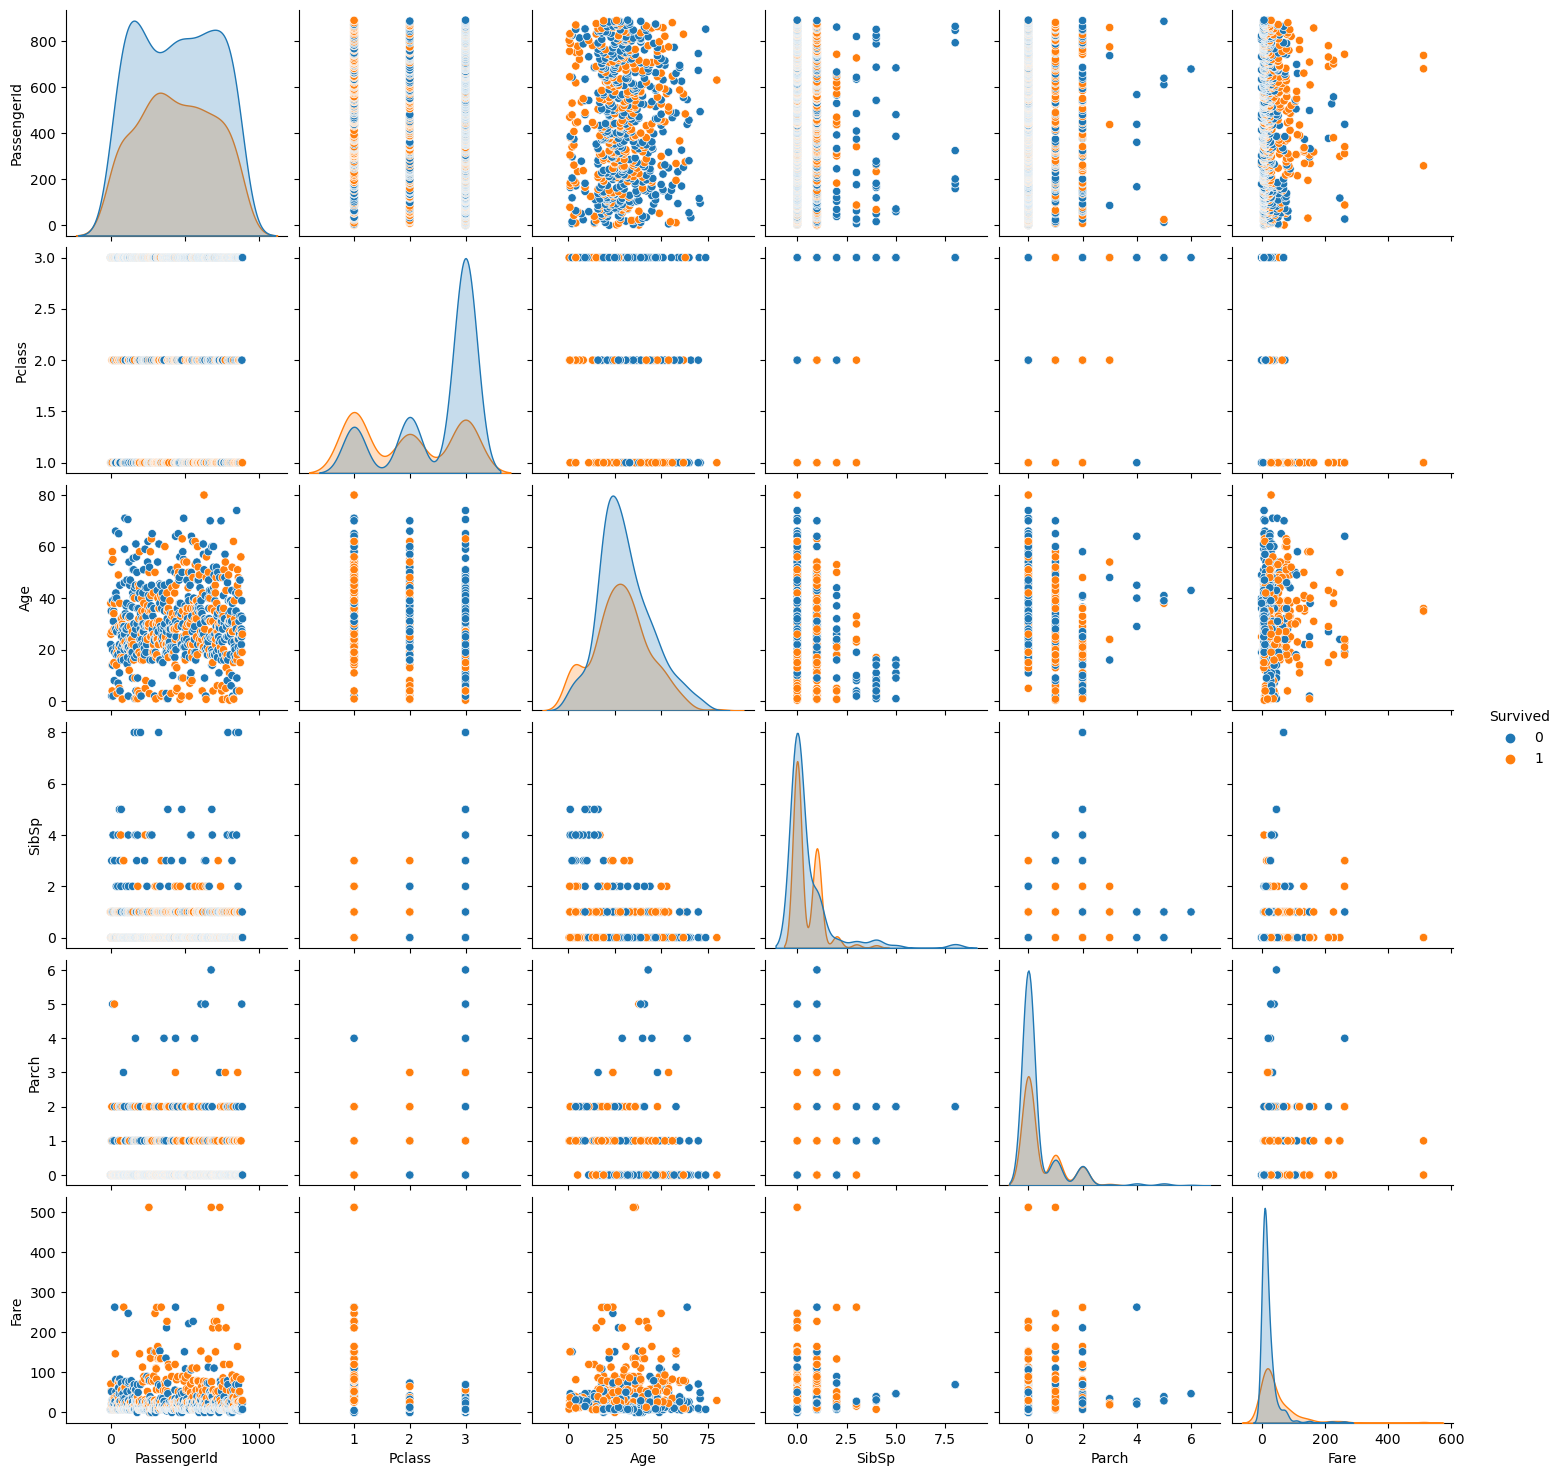

Pair plot shows relationships between numerical features, color-coded by survival status.


In [211]:
# Pair plot to visualize relationships between features
sns.pairplot(titanic_df, hue='Survived')
plt.show()
print("Pair plot shows relationships between numerical features, color-coded by survival status.")

In [212]:
# Check for missing values
missing_values = titanic_df.isnull().sum()
print(missing_values)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [213]:
# Drop columns with high missing values or not necessary for the model
titanic_df.drop(columns=['Cabin', 'PassengerId', 'Name', 'Ticket'], inplace=True)

In [214]:
# Handle missing values
titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)
titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0], inplace=True)
print(titanic_df.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [215]:
# Prepare the data for training
X = titanic_df.drop(columns=['Survived'])
y = titanic_df['Survived']

In [216]:
# Convert categorical features to numerical
X = pd.get_dummies(X, drop_first=True)

In [217]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [218]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [219]:
# Function to train and evaluate a classifier with timing
def train_and_evaluate_classifier(classifier, classifier_name):
    start_time = time.time()
    classifier.fit(X_train, y_train)
    execution_time = time.time() - start_time
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Results for {classifier_name}:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f"Execution Time: {execution_time:.4f} seconds")
    ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)
    plt.title(f'Confusion Matrix for {classifier_name}')
    plt.show()
    print(f"Confusion matrix and classification report for {classifier_name} show the performance of the model, including precision, recall, and F1-score.")
    # Plot ROC curve
    # Fix for classifiers like SVC that don’t support predict_proba
    if hasattr(classifier, "predict_proba"):
        y_prob = classifier.predict_proba(X_test)[:, 1]
    else:
        y_prob = classifier.decision_function(X_test)  # Use decision_function for SVC

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {classifier_name}')
    plt.legend(loc="lower right")
    plt.show()
    print(f"ROC curve for {classifier_name} shows the trade-off between true positive rate and false positive rate.")
    return accuracy, execution_time, roc_auc


Training and evaluating SVM classifier...
Results for SVM Classifier:
[[88 17]
 [22 52]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       105
           1       0.75      0.70      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179

Execution Time: 0.1142 seconds


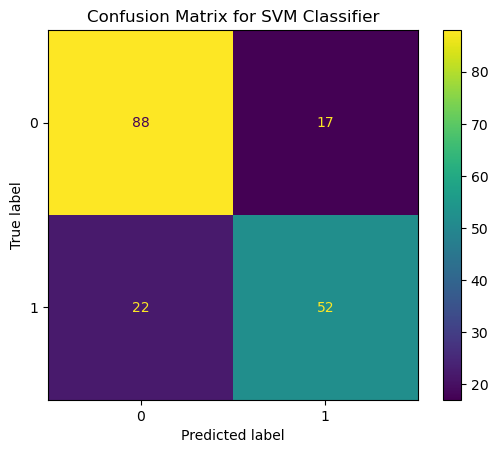

Confusion matrix and classification report for SVM Classifier show the performance of the model, including precision, recall, and F1-score.


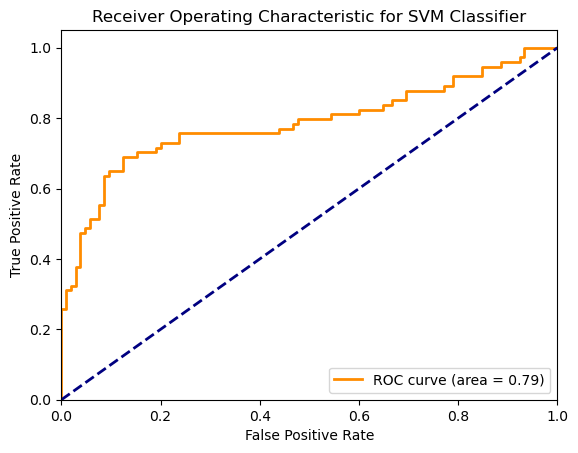

ROC curve for SVM Classifier shows the trade-off between true positive rate and false positive rate.


In [220]:
# Train and evaluate SVM classifier
print("\nTraining and evaluating SVM classifier...")
svm_classifier = SVC(kernel='linear', probability=True)
svm_accuracy, svm_execution_time, svm_roc_auc = train_and_evaluate_classifier(svm_classifier, "SVM Classifier")


Training and evaluating MLP classifier...
Results for MLP Classifier:
[[93 12]
 [21 53]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.72      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179

Execution Time: 0.9402 seconds


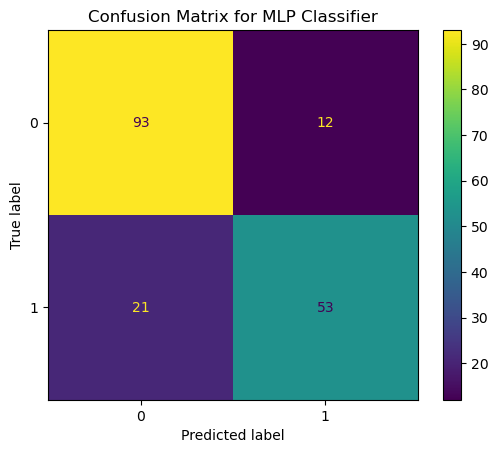

Confusion matrix and classification report for MLP Classifier show the performance of the model, including precision, recall, and F1-score.


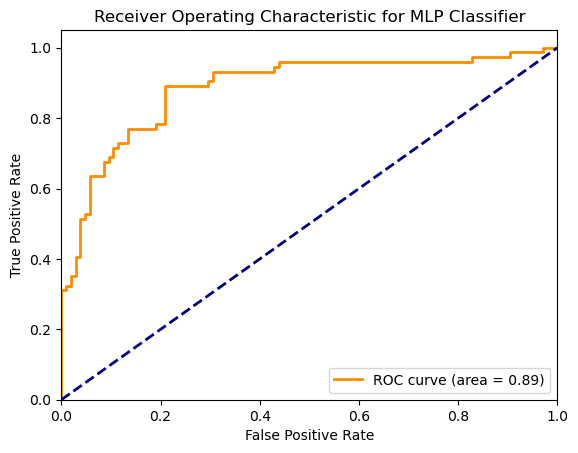

ROC curve for MLP Classifier shows the trade-off between true positive rate and false positive rate.


In [221]:
# Train and evaluate MLP classifier
print("\nTraining and evaluating MLP classifier...")
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, solver='adam', random_state=42)
mlp_accuracy, mlp_execution_time, mlp_roc_auc = train_and_evaluate_classifier(mlp_classifier, "MLP Classifier")


Training and evaluating Random Forest classifier...
Results for Random Forest Classifier:
[[91 14]
 [18 56]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.76      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

Execution Time: 0.3356 seconds


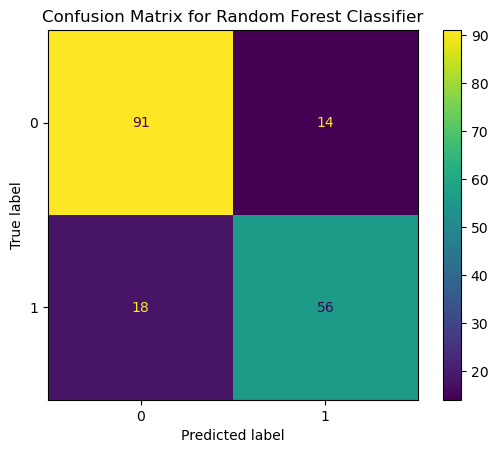

Confusion matrix and classification report for Random Forest Classifier show the performance of the model, including precision, recall, and F1-score.


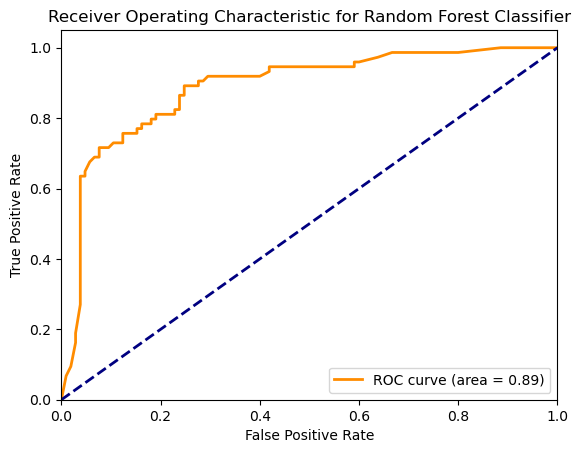

ROC curve for Random Forest Classifier shows the trade-off between true positive rate and false positive rate.


In [222]:

# Train and evaluate Random Forest classifier
print("\nTraining and evaluating Random Forest classifier...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_accuracy, rf_execution_time, rf_roc_auc = train_and_evaluate_classifier(rf_classifier, "Random Forest Classifier")


Training and evaluating Gradient Boosting classifier...
Results for Gradient Boosting Classifier:
[[94 11]
 [24 50]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.84       105
           1       0.82      0.68      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.80      0.80       179

Execution Time: 0.2735 seconds


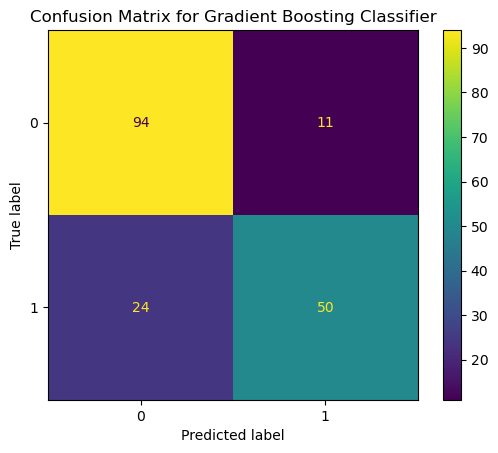

Confusion matrix and classification report for Gradient Boosting Classifier show the performance of the model, including precision, recall, and F1-score.


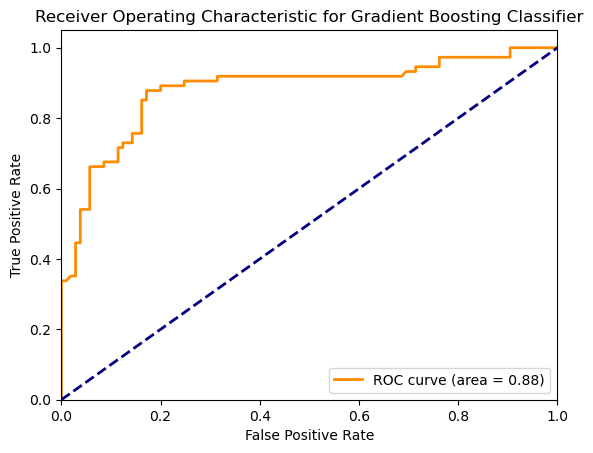

ROC curve for Gradient Boosting Classifier shows the trade-off between true positive rate and false positive rate.


In [223]:
# Train and evaluate Gradient Boosting classifier
print("\nTraining and evaluating Gradient Boosting classifier...")
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_accuracy, gb_execution_time, gb_roc_auc = train_and_evaluate_classifier(gb_classifier, "Gradient Boosting Classifier")


Visualizing feature importance for Random Forest and Gradient Boosting classifiers...


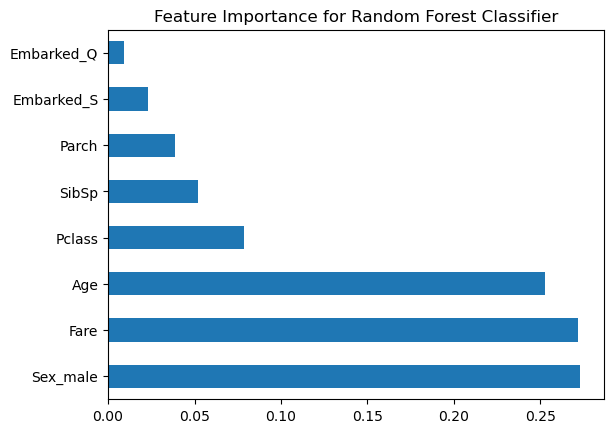

Feature importance plot for Random Forest Classifier shows the most influential features in the model.


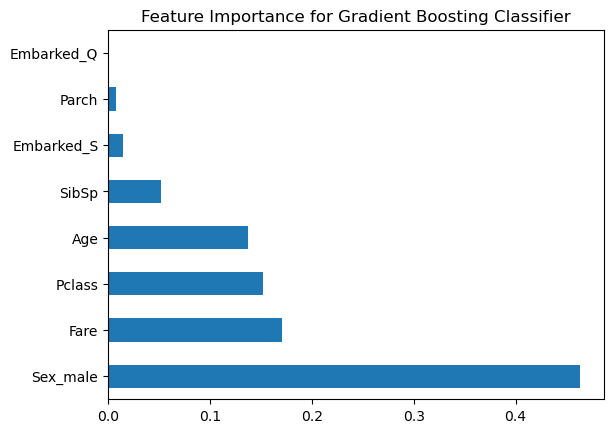

Feature importance plot for Gradient Boosting Classifier shows the most influential features in the model.


In [224]:
# Visualize feature importance for Random Forest and Gradient Boosting
def plot_feature_importance(classifier, classifier_name):
    feature_importances = pd.Series(classifier.feature_importances_, index=X.columns)
    feature_importances.nlargest(10).plot(kind='barh')
    plt.title(f'Feature Importance for {classifier_name}')
    plt.show()
    print(f"Feature importance plot for {classifier_name} shows the most influential features in the model.")

print("\nVisualizing feature importance for Random Forest and Gradient Boosting classifiers...")
plot_feature_importance(rf_classifier, "Random Forest Classifier")
plot_feature_importance(gb_classifier, "Gradient Boosting Classifier")

In [225]:
# Summary of execution times and accuracies
execution_times = {
    "SVM Classifier": svm_execution_time,
    "MLP Classifier": mlp_execution_time,
    "Random Forest Classifier": rf_execution_time,
    "Gradient Boosting Classifier": gb_execution_time
}

accuracies = {
    "SVM Classifier": svm_accuracy,
    "MLP Classifier": mlp_accuracy,
    "Random Forest Classifier": rf_accuracy,
    "Gradient Boosting Classifier": gb_accuracy
}

roc_aucs = {
    "SVM Classifier": svm_roc_auc,
    "MLP Classifier": mlp_roc_auc,
    "Random Forest Classifier": rf_roc_auc,
    "Gradient Boosting Classifier": gb_roc_auc
}

print("\nExecution Times for Classifiers:")
for classifier_name, exec_time in execution_times.items():
    print(f"{classifier_name}: {exec_time:.4f} seconds")

print("\nAccuracies for Classifiers:")
for classifier_name, accuracy in accuracies.items():
    print(f"{classifier_name}: {accuracy:.4f}")
    
print("\nROC AUC Scores for Classifiers:")
for classifier_name, roc_auc in roc_aucs.items():
    print(f"{classifier_name}: {roc_auc:.4f}")


Execution Times for Classifiers:
SVM Classifier: 0.1142 seconds
MLP Classifier: 0.9402 seconds
Random Forest Classifier: 0.3356 seconds
Gradient Boosting Classifier: 0.2735 seconds

Accuracies for Classifiers:
SVM Classifier: 0.7821
MLP Classifier: 0.8156
Random Forest Classifier: 0.8212
Gradient Boosting Classifier: 0.8045

ROC AUC Scores for Classifiers:
SVM Classifier: 0.7867
MLP Classifier: 0.8866
Random Forest Classifier: 0.8866
Gradient Boosting Classifier: 0.8810


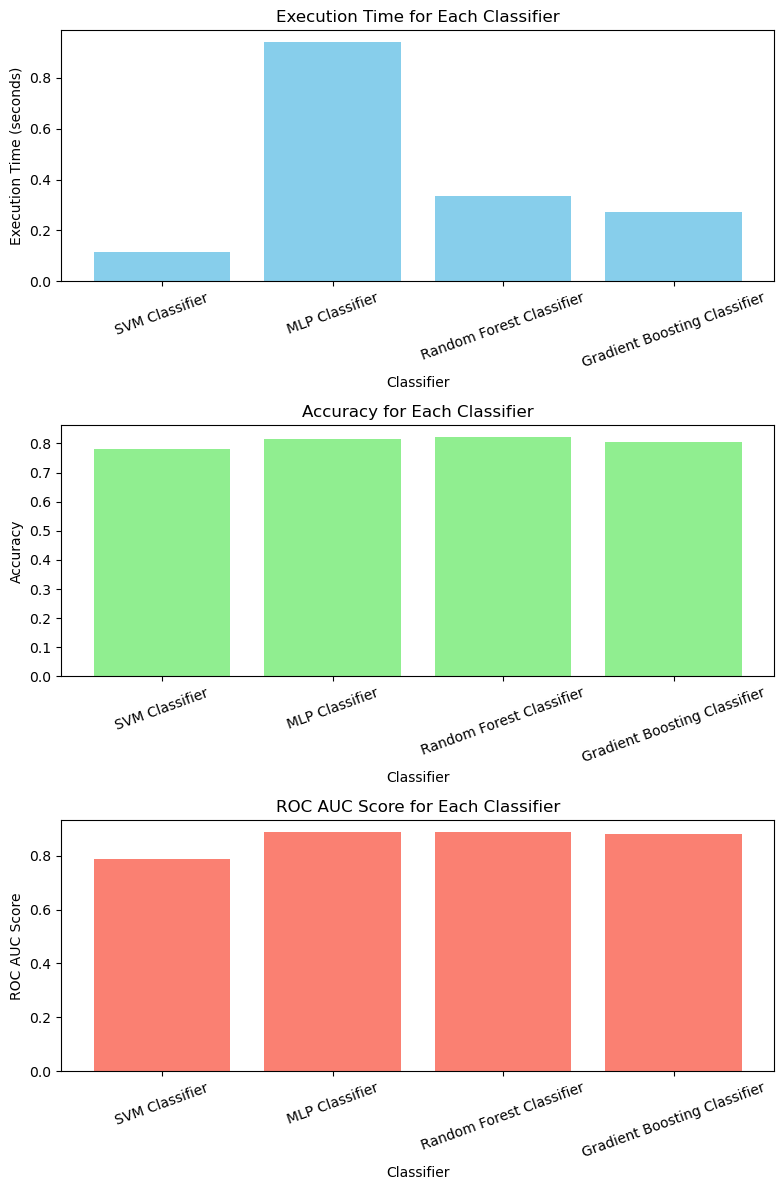

In [226]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))  # 3 rows, 1 column

# Execution Time Bar Chart
axes[0].bar(execution_times.keys(), execution_times.values(), color='skyblue')
axes[0].set_xlabel('Classifier')
axes[0].set_ylabel('Execution Time (seconds)')
axes[0].set_title('Execution Time for Each Classifier')
axes[0].tick_params(axis='x', rotation=20)  # Rotate labels slightly

# Accuracy Bar Chart
axes[1].bar(accuracies.keys(), accuracies.values(), color='lightgreen')
axes[1].set_xlabel('Classifier')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy for Each Classifier')
axes[1].tick_params(axis='x', rotation=20)  # Rotate labels slightly

# ROC AUC Score Bar Chart
axes[2].bar(roc_aucs.keys(), roc_aucs.values(), color='salmon')
axes[2].set_xlabel('Classifier')
axes[2].set_ylabel('ROC AUC Score')
axes[2].set_title('ROC AUC Score for Each Classifier')
axes[2].tick_params(axis='x', rotation=20)  # Rotate labels slightly

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [227]:
from tabulate import tabulate
import pandas as pd

# Assuming these dictionaries are populated dynamically from your model evaluations
accuracies = {
    "SVM Classifier": svm_accuracy,
    "MLP Classifier": mlp_accuracy,
    "Random Forest Classifier": rf_accuracy,
    "Gradient Boosting Classifier": gb_accuracy
}

roc_aucs = {
    "SVM Classifier": svm_roc_auc,
    "MLP Classifier": mlp_roc_auc,
    "Random Forest Classifier": rf_roc_auc,
    "Gradient Boosting Classifier": gb_roc_auc
}

execution_times = {
    "SVM Classifier": svm_execution_time,
    "MLP Classifier": mlp_execution_time,
    "Random Forest Classifier": rf_execution_time,
    "Gradient Boosting Classifier": gb_execution_time
}

# Create DataFrame dynamically
df = pd.DataFrame({
    "Classifier": list(accuracies.keys()),
    "Accuracy": [round(accuracies[clf], 4) for clf in accuracies],
    "ROC AUC": [round(roc_aucs[clf], 4) for clf in roc_aucs],
    "Execution Time (seconds)": [round(execution_times[clf], 4) for clf in execution_times]
})

# Print the table in SQL-style format
print(tabulate(df, headers="keys", tablefmt="psql", showindex=False))


+------------------------------+------------+-----------+----------------------------+
| Classifier                   |   Accuracy |   ROC AUC |   Execution Time (seconds) |
|------------------------------+------------+-----------+----------------------------|
| SVM Classifier               |     0.7821 |    0.7867 |                     0.1142 |
| MLP Classifier               |     0.8156 |    0.8866 |                     0.9402 |
| Random Forest Classifier     |     0.8212 |    0.8866 |                     0.3356 |
| Gradient Boosting Classifier |     0.8045 |    0.881  |                     0.2735 |
+------------------------------+------------+-----------+----------------------------+


<b>Final Interpretation of Classifier Performance:</b> <br>
Based on the evaluation metrics of Accuracy, ROC AUC, and Execution Time, we can summarize the model performances as follows:<br>
<br>
<b>Best Overall Model:</b><br>
<br>
(i)Random Forest Classifier achieved the highest accuracy (0.8212) and ROC AUC (0.8866), making it the best classifier in terms of prediction performance.<br>

(ii)MLP Classifier also performed very well, with similar ROC AUC (0.8866) and slightly lower accuracy (0.8156).<br>

<b>Trade-off Between Performance and Speed:</b><br>
<br>
(i)SVM Classifier had the fastest execution time (0.1142s) but had the lowest accuracy (0.7821) and ROC AUC (0.7867). This means it is computationally efficient but not as strong in predictive performance.<br>
<br>
(ii)MLP Classifier had the longest execution time (0.9402s) but showed high predictive performance (ROC AUC = 0.8866).<br>
<br>
<b>Balanced Choice:</b><br>
<br>
(i)Gradient Boosting Classifier had a high ROC AUC (0.881) and accuracy (0.8045), making it a strong alternative to Random Forest.<br>
<br>
(ii)Its execution time (0.2735s) is faster than MLP but slower than SVM.<br>

<b>Final Conclusion</b> <br>
If we need the best classifier for predictions: <b>Random Forest</b><br>
<br>
If we need a fast model with reasonable performance: <b>SVM</b><br>
<br>
If we need a deep learning approach with high performance: <b>MLP</b><br>
<br>
If we need a good balance of performance and speed: <b>Gradient Boosting</b><br>
<br>
<b>Final Verdict:</b><br>
    <b>Random Forest</b> is the best choice for <b>accuracy</b> and <b>AUC</b>, while <b>SVM</b> is the best for <b>speed</b>.<br>